# Split Halves Analysis
This notebook will conduct an analysis of inter-rater reliability using split-halves analysis
1. We first split the dataset into our two conditions: interesting/stable
2. We then take each tower and randomly assign the rating to two groups.
3. We calcualte the mean for each group in each tower
4. Then take the correlation of the two group means across towers.

We run this process many times to get a sampling distribution of correlations, then compare the mean correlation (and CI) of stable to interesting using a t-test

In [2]:
import pandas as pd
import numpy as np
from statistics import mean
%precision %.2f
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Read in most recet data

In [3]:
df = pd.read_csv('curiotower_raw_data_run_0.csv')
print(df.shape)
df.head(2)

(24048, 47)


,Unnamed: 0,_id,type,iterationName,condition,prompt,towerID,image_url,num_blocks,stim_version,...,internal_node_id,workerId,hitID,aID,eventType,rt,responses,question_order,stability,viewpoint
0,2,5fffc37cf2e06b2b75acd797,image-button-response,run_0,stable,How stable is this?,curiotower_8_low_0005_1,https://curiotower-tdw.s3.amazonaws.com/curiot...,8.0,tdw-height3Jitter3,...,0.0-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low,1
1,4,5fffc383f2e06b2b75acd799,image-button-response,run_0,stable,How stable is this?,curiotower_2_low_0000_0,https://curiotower-tdw.s3.amazonaws.com/curiot...,2.0,tdw-height3Jitter3,...,0.0-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low,0


### split into two conditions

In [4]:
df_stable = df[df['condition'] == 'stable']
df_interesting = df[df['condition'] == 'interesting']

### Create dummy df of prolific IDs for randomization

In [5]:
df_subject = pd.DataFrame(df['prolificID'].unique(), 
                           columns = ['prolificID'])
df_subject['group_num'] = 0


## split-halves design

sampling from: stable
sampling from: interesting


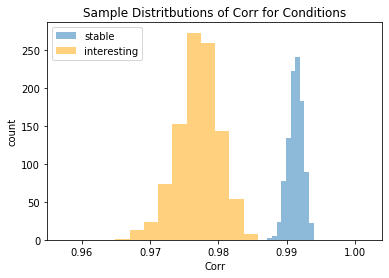

In [6]:
conditions = ['stable', 'interesting']
corr_stable = []
corr_interesting = []
for condition in conditions:
    print('sampling from:', condition)
    df_condition = df[df['condition'] == condition]
    for i in range(0,1000):
        rand_group = np.random.randint(2, size=len(df_condition['towerID']))
        df_condition['rand_group'] = pd.Series(rand_group)

        out = df_condition.pivot_table(index=["towerID"], 
                            columns='rand_group', 
                            values='button_pressed',
                            aggfunc='mean').reset_index()
        out.columns = ['towerID', 'group0', 'group1']
        sample_corr = out['group0'].corr(out['group1'])
        if condition == 'stable':
            #corr_stable.append(sample_corr)
            corr_stable.append(2*sample_corr/(1+sample_corr))
        elif condition == 'interesting':
            #corr_interesting.append(sample_corr)
            #Spearman brown correction
            corr_interesting.append(2*sample_corr/(1+sample_corr))



plt.xlim([min(corr_stable + corr_interesting)-0.01, max(corr_stable + corr_interesting)+0.01])

plt.hist(corr_stable, alpha=0.5, label = 'stable')
plt.hist(corr_interesting, alpha = 0.5, color = 'orange', label = 'interesting')
plt.title('Sample Distritbutions of Corr for Conditions')
plt.xlabel('Corr')
plt.ylabel('count')
plt.legend()
plt.show()

In [7]:
print("Mean prop for stable:", 
      round(mean(corr_stable),3),
      "+/-", 
      round((1.96*np.std(corr_stable)/
       np.sqrt(len(corr_stable))),3))
print("Mean prop for interesting:",
      round(mean(corr_interesting),3), 
      "+/-", 
      round((1.96*np.std(corr_interesting)/
       np.sqrt(len(corr_interesting))),10))

Mean prop for stable: 0.991 +/- 0.0
Mean prop for interesting: 0.977 +/- 0.0001899064


## Now caluclate the r for each model and copmute the proportion of variance explained


In [14]:
dat = df[df['condition'] == 'interesting']
dat.columns
dat = pd.get_dummies(dat, columns=['stability'])

In [19]:
dat.columns

Index(['Unnamed: 0', '_id', 'type', 'iterationName', 'condition', 'prompt',
       'towerID', 'image_url', 'num_blocks', 'stim_version', 'catch_trial',
       'games', 'trialNum', 'prolificID', 'studyID', 'sessionID', 'gameID',
       'image_html', 'session_id', 'upper_bound', 'lower_bound', 'choices',
       'button_html', 'message', 'stimulus_duration', 'trial_duration',
       'trial_num', 'margin_vertical', 'margin_horizontal',
       'response_ends_trial', 'reaction_time', 'button_pressed',
       'startTrialTime', 'endTrialTime', 'trial_type', 'trial_index',
       'time_elapsed', 'internal_node_id', 'workerId', 'hitID', 'aID',
       'eventType', 'rt', 'responses', 'question_order', 'viewpoint',
       'stability_high', 'stability_low', 'stability_med'],
      dtype='object')

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

regressors = ['num_blocks']
# regressors = ['num_blocks', 'stability_high', 'stability_low', 'stability_med']
#regressors = ['num_blocks', 'stability_high', 'stability_low', 'stability_med']
# X = dat[regressors]
# interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
# X = interaction.fit_transform(X)

regressors = ['num_blocks', 'stability_high', 'stability_low', 'stability_med']
X = dat[regressors]
y = dat['button_pressed']
##Sklearn regression
reg = LinearRegression().fit(X, y)
reg.score(X,y)




0.5620551681968609

## Mode analysis

for each condition;
    for each tower;
         calculate proportion of responses selecting mode; 
               --> then average acrosss towers (and report CI)

In [7]:
#annoying function to get min when equal counts for mode
def try_min(value):
        try:
            return min(value)
        except:
            return value

In [8]:
df_stable_mode = df[df['condition']=='stable'].groupby(['towerID']).agg(pd.Series.mode).reset_index()[['towerID','button_pressed']]
df_stable_mode['mode'] = df_stable_mode['button_pressed'].apply(lambda x: try_min(x))


In [9]:


conditions = ['stable', 'interesting']
towers = df['towerID'].unique()
mode_proportion_list_stable = []
mode_proportion_list_interesting = []
for condition in conditions:
    print('sampling from:', condition)
    df_condition = df[df['condition'] == condition]
    df_mode = df_condition.groupby(['towerID']).agg(pd.Series.mode).reset_index()[['towerID','button_pressed']]
    df_mode['mode'] = df_mode['button_pressed'].apply(lambda x: try_min(x))

    for tower in towers:
        mode_response = int(df_mode[df_mode['towerID'] == tower]['mode'])
        prop = (len(df_condition.loc[(df_condition['towerID'] == tower) & (df_condition['button_pressed'] == mode_response)])/
                len(df_condition.loc[(df_condition['towerID'] == tower)]))
        if condition == 'stable':
            mode_proportion_list_stable.append(prop)
        elif condition == 'interesting':
            mode_proportion_list_interesting.append(prop)
        
        

print("Mean prop for stable:", 
      round(mean(mode_proportion_list_stable),3),
      "+/-", 
      round((1.96*np.std(mode_proportion_list_stable)/
       np.sqrt(len(mode_proportion_list_stable))),3))
print("Mean prop for interesting:",
      round(mean(mode_proportion_list_interesting),3), 
      "+/-", 
      round((1.96*np.std(mode_proportion_list_interesting)/
       np.sqrt(len(mode_proportion_list_interesting))),3))
    

sampling from: stable
sampling from: interesting
Mean prop for stable: 0.516 +/- 0.027
Mean prop for interesting: 0.542 +/- 0.031
